# Customer segmentation (clustering)
## Hotel Customer Data
### This notebook was developed by:

- João Venichand - 20211644
- Gonçalo Custódio - 20211643
- Diogo Correia - 20211586
- Duarte Emanuel - 200564

### Data Description
Dataset related to customer behavior and preferences in a hotel context. Contains historical booking patterns, revenue data, and customer-specific preferences.

#### Customer Information:
- **ID**: Unique customer identifier (numeric)
- **Nationality**: Customer nationality (categorical: e.g., 'BRA', 'USA')
- **Age**: Customer age (numeric)
- **DaysSinceCreation**: Days since the customer account was created (numeric)
- **NameHash**: Anonymized hash of the customer’s name (text)
- **DocIDHash**: Anonymized hash of the customer’s ID document (text)
- **LodgingRevenue**: Total lodging revenue (numeric)
- **OtherRevenue**: Total revenue from non-lodging services (e.g., food, spa) (numeric)
- **MarketSegment**: Customer market segment (e.g., 'corporate', 'leisure') (categorical)

#### Booking Behaviour:
- **AverageLeadTime**: Average days between booking and arrival date (numeric)
- **BookingsCanceled**: Total canceled bookings by the customer (numeric)
- **BookingsNoShowed**: Total "no-show" bookings (numeric)
- **BookingsCheckedin**: Total bookings that resulted in stays (numeric)
- **PersonNights**: Total person-nights stayed (adults + children × nights) (numeric)
- **RoomNights**: Total room-nights stayed (rooms × nights) (numeric)
- **DistributionChannel**: Booking distribution channel (e.g., 'direct', 'agency') (categorical)

#### Customer Preferences (Binary: 0 = No, 1 = Yes)
- **SRHighFloor**: Requests rooms on higher floors
- **SRLowFloor**: Requests rooms on lower floors
- **SRMediumFloor**: Requests rooms on middle floors
- **SRAccessibleRoom**: Requests accessible rooms
- **SRBathtub**: Requests rooms with bathtubs
- **SRShower**: Requests rooms with showers
- **SRCrib**: Requests cribs
- **SRKingSizeBed**: Requests king-size beds
- **SRTwinBed**: Requests twin beds
- **SRNearElevator**: Requests rooms near elevators
- **SRAwayFromElevator**: Requests rooms away from elevators
- **SRNoAlcoholInMiniBar**: Requests mini-bars without alcohol
- **SRQuietRoom**: Requests quiet rooms

## Importing Libraries


__`Step 1`__ Import the required libraries.

In [940]:
import pandas as pd 
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import seaborn as sns
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
import umap
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Understanding 


__`Step 2`__ Import the dataset, storing it in the data frame **data**.

In [941]:
data = pd.read_csv('Case1_HotelCustomerSegmentation.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111733 entries, 0 to 111732
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    111733 non-null  int64  
 1   Nationality           111733 non-null  object 
 2   Age                   107561 non-null  float64
 3   DaysSinceCreation     111733 non-null  int64  
 4   NameHash              111733 non-null  object 
 5   DocIDHash             110732 non-null  object 
 6   AverageLeadTime       111733 non-null  int64  
 7   LodgingRevenue        111733 non-null  float64
 8   OtherRevenue          111733 non-null  float64
 9   BookingsCanceled      111733 non-null  int64  
 10  BookingsNoShowed      111733 non-null  int64  
 11  BookingsCheckedIn     111733 non-null  int64  
 12  PersonsNights         111733 non-null  int64  
 13  RoomNights            111733 non-null  int64  
 14  DistributionChannel   111733 non-null  object 
 15  

In [942]:
data.drop(columns=["NameHash", "DocIDHash", "MarketSegment"], inplace=True)

__`Step 3`__ Display the data.

In [943]:
data.head(5)

,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,1,PRT,52.0,440,59,292.0,82.3,1,0,2,...,0,0,0,0,0,0,0,0,0,0
1,2,PRT,NaN,1385,61,280.0,53.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,DEU,32.0,1385,0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,FRA,61.0,1385,93,240.0,60.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,FRA,52.0,1385,0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__`Step 4`__ Turn the ID into the index of the data.

In [944]:
if data['ID'].duplicated().any():
    print("There are duplicate IDs in the dataset.")
else:
    data.set_index('ID', inplace=True)

__`Step 5`__ Summary statistics for all variables

In [945]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Nationality,111733,199,FRA,16516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,107561.0,NaN,NaN,NaN,45.639191,17.244952,-10.0,33.0,47.0,58.0,123.0
DaysSinceCreation,111733.0,NaN,NaN,NaN,595.026599,374.657382,36.0,288.0,522.0,889.0,1385.0
AverageLeadTime,111733.0,NaN,NaN,NaN,60.833147,85.11532,-1.0,0.0,21.0,95.0,588.0
LodgingRevenue,111733.0,NaN,NaN,NaN,283.851283,379.131556,0.0,0.0,208.0,393.3,21781.0
OtherRevenue,111733.0,NaN,NaN,NaN,64.682802,123.580715,0.0,0.0,31.0,84.0,8859.25
BookingsCanceled,111733.0,NaN,NaN,NaN,0.002282,0.080631,0.0,0.0,0.0,0.0,15.0
BookingsNoShowed,111733.0,NaN,NaN,NaN,0.0006,0.028217,0.0,0.0,0.0,0.0,3.0
BookingsCheckedIn,111733.0,NaN,NaN,NaN,0.737607,0.730889,0.0,0.0,1.0,1.0,76.0
PersonsNights,111733.0,NaN,NaN,NaN,4.328318,4.630739,0.0,0.0,4.0,6.0,116.0


__`Step 6`__ Check missing values

In [946]:
print(data.isnull().sum())

Nationality                0
Age                     4172
DaysSinceCreation          0
AverageLeadTime            0
LodgingRevenue             0
OtherRevenue               0
BookingsCanceled           0
BookingsNoShowed           0
BookingsCheckedIn          0
PersonsNights              0
RoomNights                 0
DistributionChannel        0
SRHighFloor                0
SRLowFloor                 0
SRAccessibleRoom           0
SRMediumFloor              0
SRBathtub                  0
SRShower                   0
SRCrib                     0
SRKingSizeBed              0
SRTwinBed                  0
SRNearElevator             0
SRAwayFromElevator         0
SRNoAlcoholInMiniBar       0
SRQuietRoom                0
dtype: int64


__`Step 7`__ Histograms of numeric variables

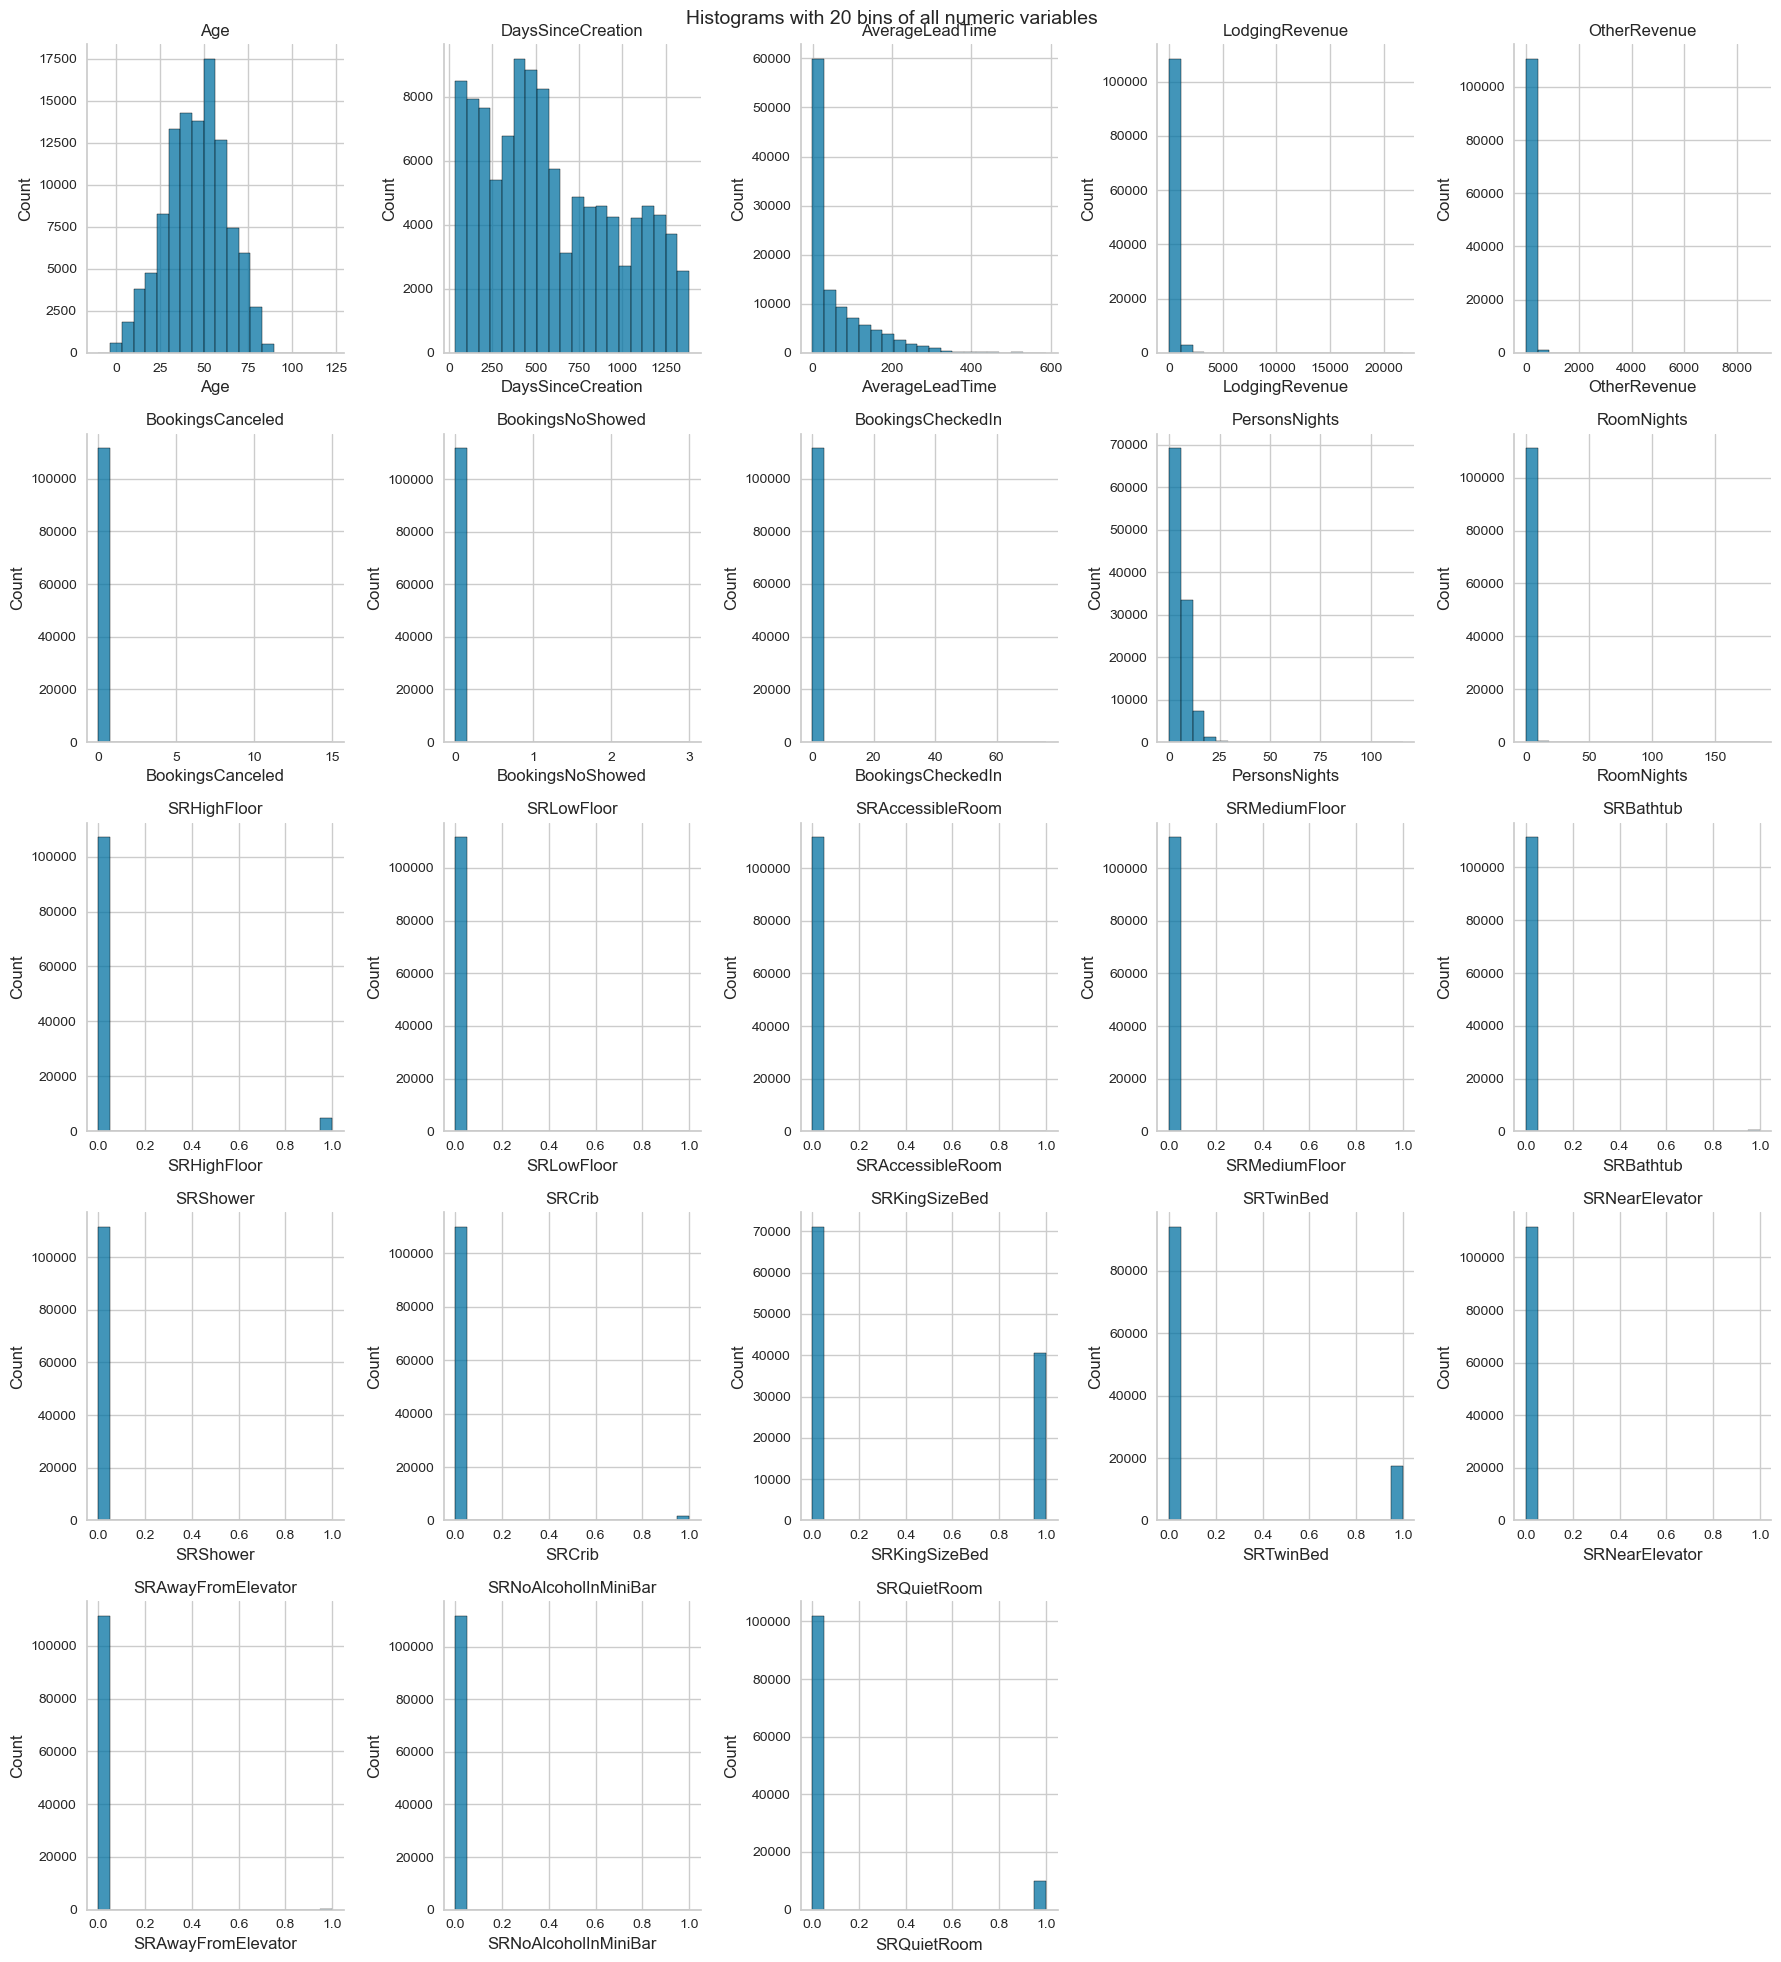

In [947]:
subPlots_label_fontSize = 12
plots_Title_fontSize = 14
numerical_data = data.select_dtypes(include=[np.number]).columns.tolist()
num_vars = len(numerical_data)
num_cols = 5
num_rows = (num_vars // num_cols) + (1 if num_vars % num_cols != 0 else 0)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
ax = ax.flatten()

for i, var in enumerate(numerical_data):
    sns.histplot(data=data,
                 bins=20,
                 x=var,
                 ax=ax[i],
                 kde=False)
    ax[i].set_title(var, fontsize=subPlots_label_fontSize)

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=plots_Title_fontSize)
plt.tight_layout()
plt.show()

__`Step 8`__ Boxplot of numeric variables

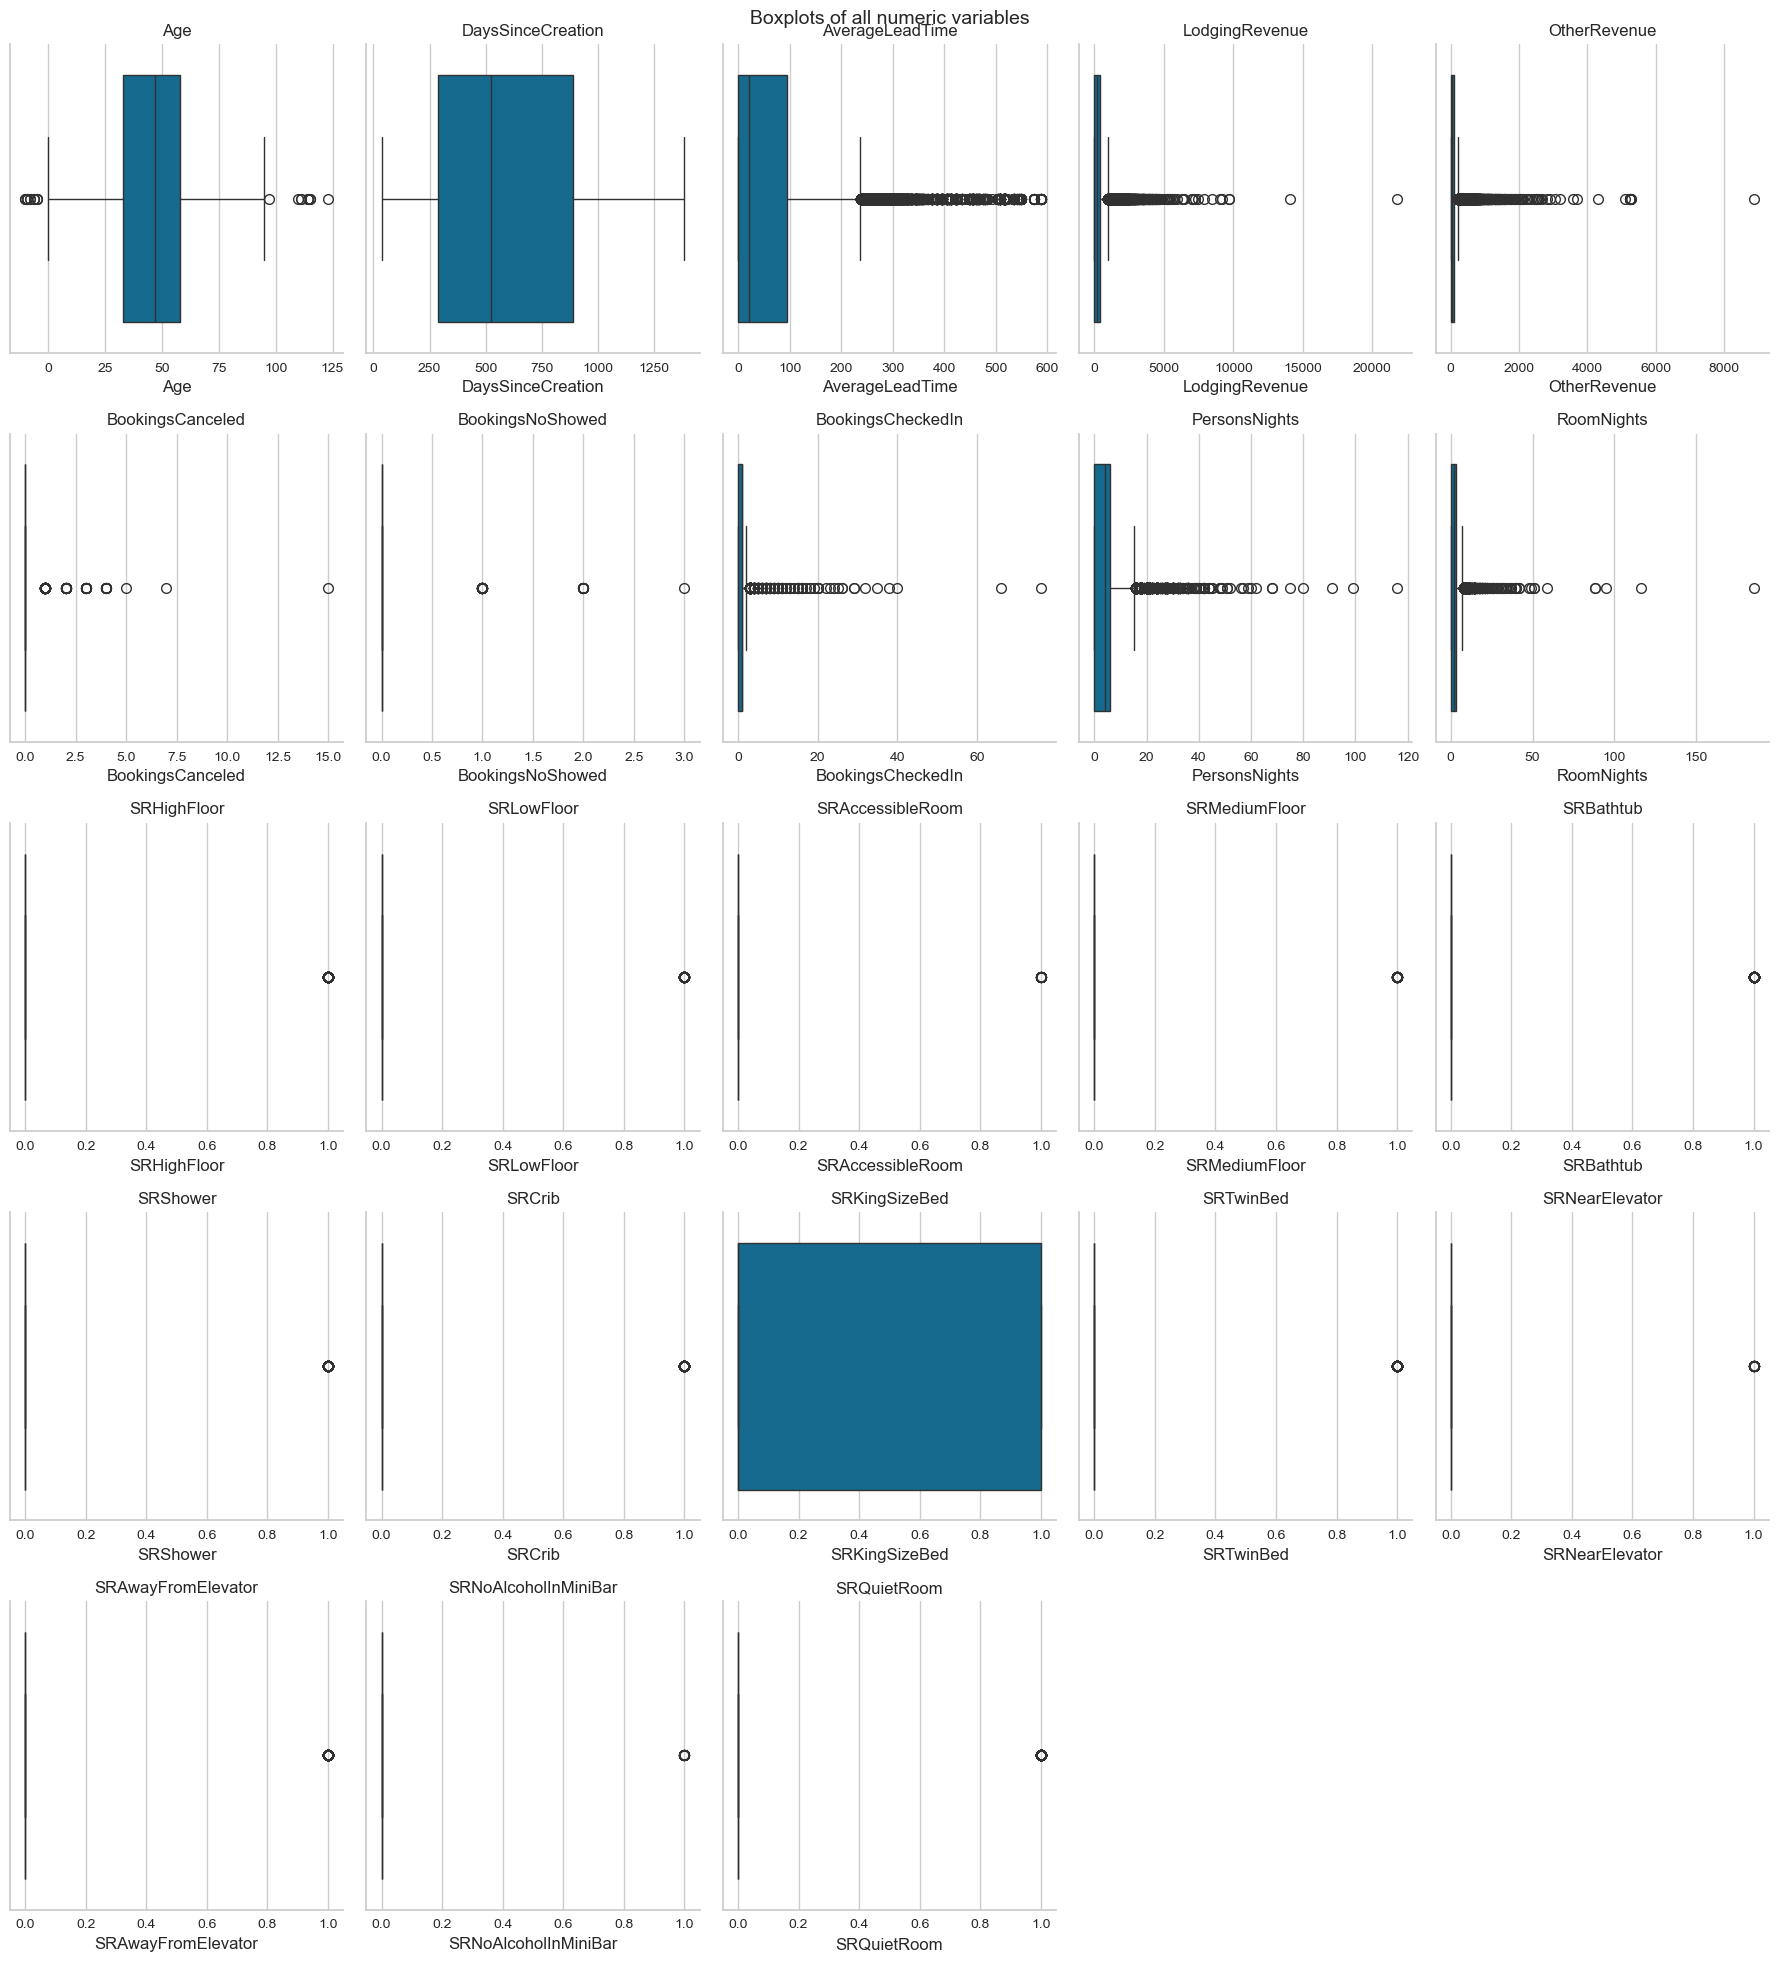

In [948]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
ax = ax.flatten()

for i, var in enumerate(numerical_data):
    sns.boxplot(data=data, x=var, ax=ax[i])
    ax[i].set_title(var, fontsize=subPlots_label_fontSize)

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

sns.despine()
fig.suptitle("Boxplots of all numeric variables", fontsize=plots_Title_fontSize)
plt.tight_layout()
plt.show()

__`Step 9`__ Check if the Customer Preferences have only binary values (0 or 1)

In [949]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]

data[binary_cols] = data[binary_cols].apply(pd.to_numeric, errors='coerce')

In [950]:
for col in binary_cols:
    unique_values = data[col].unique()
    if not set(unique_values).issubset({0, 1}):
        print(f"Column {col} contains values other than 0 and 1: {unique_values}")

__`Step 10`__ Distribution of the variables with binary values (0 or 1)

In [951]:
for col in binary_cols:
    print(f"Value counts for {col}:")
    print(data[col].value_counts(dropna=False))
    print("-" * 40)

Value counts for SRHighFloor:
SRHighFloor
0    106983
1      4750
Name: count, dtype: int64
----------------------------------------
Value counts for SRLowFloor:
SRLowFloor
0    111587
1       146
Name: count, dtype: int64
----------------------------------------
Value counts for SRMediumFloor:
SRMediumFloor
0    111647
1        86
Name: count, dtype: int64
----------------------------------------
Value counts for SRAccessibleRoom:
SRAccessibleRoom
0    111708
1        25
Name: count, dtype: int64
----------------------------------------
Value counts for SRBathtub:
SRBathtub
0    111383
1       350
Name: count, dtype: int64
----------------------------------------
Value counts for SRShower:
SRShower
0    111551
1       182
Name: count, dtype: int64
----------------------------------------
Value counts for SRCrib:
SRCrib
0    109925
1      1808
Name: count, dtype: int64
----------------------------------------
Value counts for SRKingSizeBed:
SRKingSizeBed
0    71144
1    40589
Name: cou

__`Step 11`__ Distribution of the categorical variables

In [952]:
categorical_cols = ["Nationality", "DistributionChannel"]
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [953]:
nationality_cols = [col for col in data.columns if col.startswith("Nationality_")]
nationality_counts = data[nationality_cols].sum().sort_values(ascending=False)
distribution_cols = [col for col in data.columns if col.startswith("DistributionChannel_")]
distribution_counts = data[distribution_cols].sum().sort_values(ascending=False)

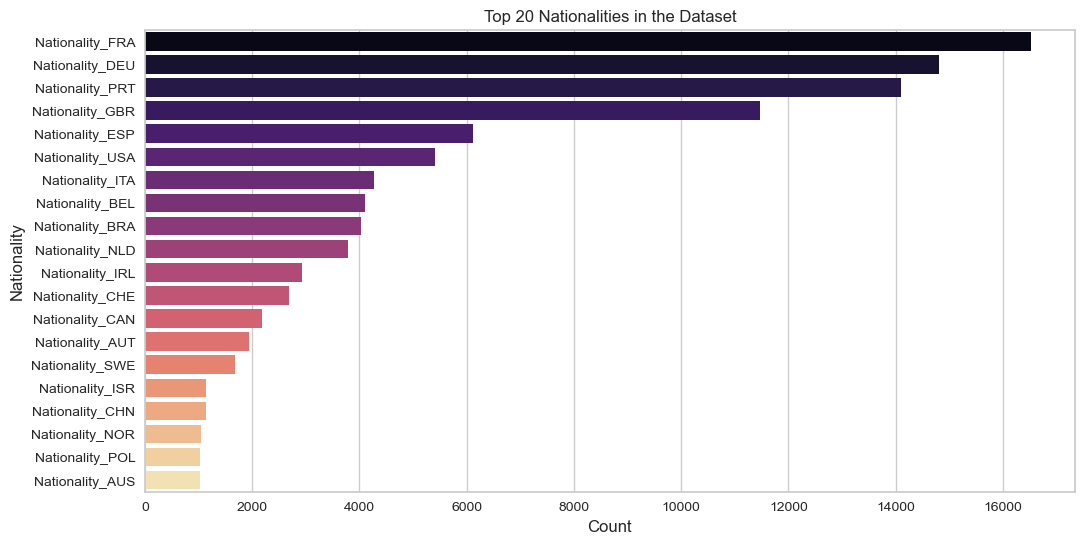

In [954]:
top_n = 20
top_nationalities = nationality_counts.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_nationalities.values, y=top_nationalities.index, palette="magma")
plt.title(f"Top {top_n} Nationalities in the Dataset")
plt.xlabel("Count")
plt.ylabel("Nationality")
plt.show()

In [955]:
data[nationality_cols] = data[nationality_cols].astype(int)

In [956]:
threshold = len(data) * 0.05
nationality_counts = data[nationality_cols].sum()
top_nationalities = nationality_counts[nationality_counts > threshold].index.tolist()
data["Nationality_Processed"] = data[top_nationalities].idxmax(axis=1)
data["Nationality_Processed"] = data["Nationality_Processed"].fillna("Other")
data["Nationality_Processed"] = data["Nationality_Processed"].astype("category")
data.drop(columns=nationality_cols, inplace=True)

print(data["Nationality_Processed"].value_counts())

Nationality_Processed
Nationality_DEU    63531
Nationality_FRA    16516
Nationality_PRT    14101
Nationality_GBR    11462
Nationality_ESP     6123
Name: count, dtype: int64


C:\Users\gonca\AppData\Local\Temp\ipykernel_40544\3475910094.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["Nationality_Processed"] = data[top_nationalities].idxmax(axis=1)


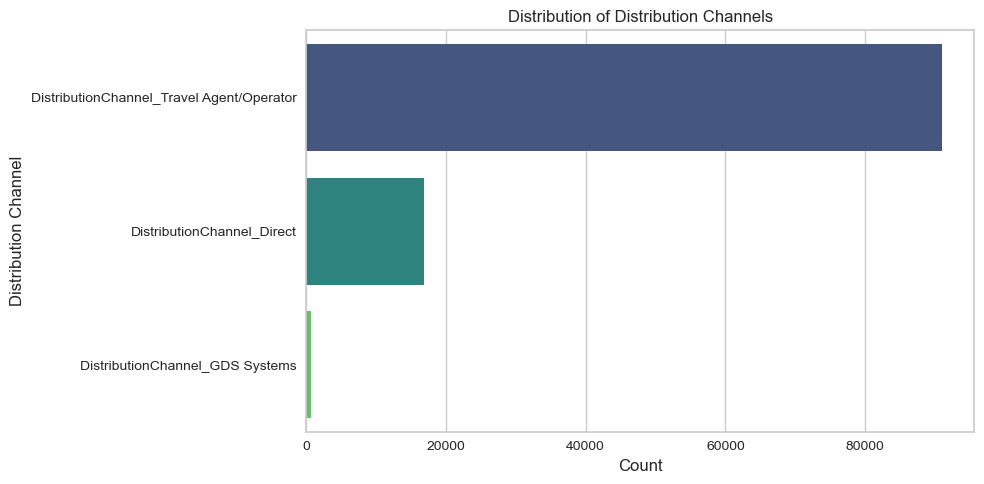

In [957]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(x=distribution_counts.values, y=distribution_counts.index, palette="viridis", ax=ax)
ax.set_title("Distribution of Distribution Channels")
ax.set_xlabel("Count")
ax.set_ylabel("Distribution Channel")

plt.tight_layout()
plt.show()

In [958]:
bool_cols = ['DistributionChannel_Direct', 'DistributionChannel_GDS Systems', 'DistributionChannel_Travel Agent/Operator']
data[bool_cols] = data[bool_cols].astype(int)

In [959]:
print(data['BookingsNoShowed'].value_counts())

BookingsNoShowed
0    111676
1        48
2         8
3         1
Name: count, dtype: int64


In [960]:
print(data['BookingsCheckedIn'].value_counts())

BookingsCheckedIn
1     76474
0     33198
2      1634
3       201
4        57
5        33
7        30
6        19
9        13
8        12
10       12
15        7
11        7
16        5
13        5
20        4
12        3
29        2
26        2
18        2
40        1
22        1
24        1
19        1
25        1
14        1
23        1
76        1
66        1
32        1
17        1
38        1
35        1
Name: count, dtype: int64


Since the BookingsNoShowed variable is highly imbalanced, we can simplify it into a binary feature:

- 0 → Never No-Showed
- 1 or more → At Least One No-Show

In [961]:
data["HasNoShow"] = (data["BookingsNoShowed"] > 0).astype(int)

Since almost all customers have 0 canceled bookings, we can simplify it:

- 0 → Never canceled
- 1 or more → At least one cancellation

In [962]:
data["HasCanceled"] = (data["BookingsCanceled"] > 0).astype(int)

Since BookingsCheckedIn is right-skewed, a log transformation can make it more normally distributed:

In [963]:
data["Log_BookingsCheckedIn"] = np.log1p(data["BookingsCheckedIn"])

In [964]:
data.drop(columns=["BookingsNoShowed", "BookingsCanceled", "BookingsCheckedIn"], inplace=True)

### Correlation Matrix

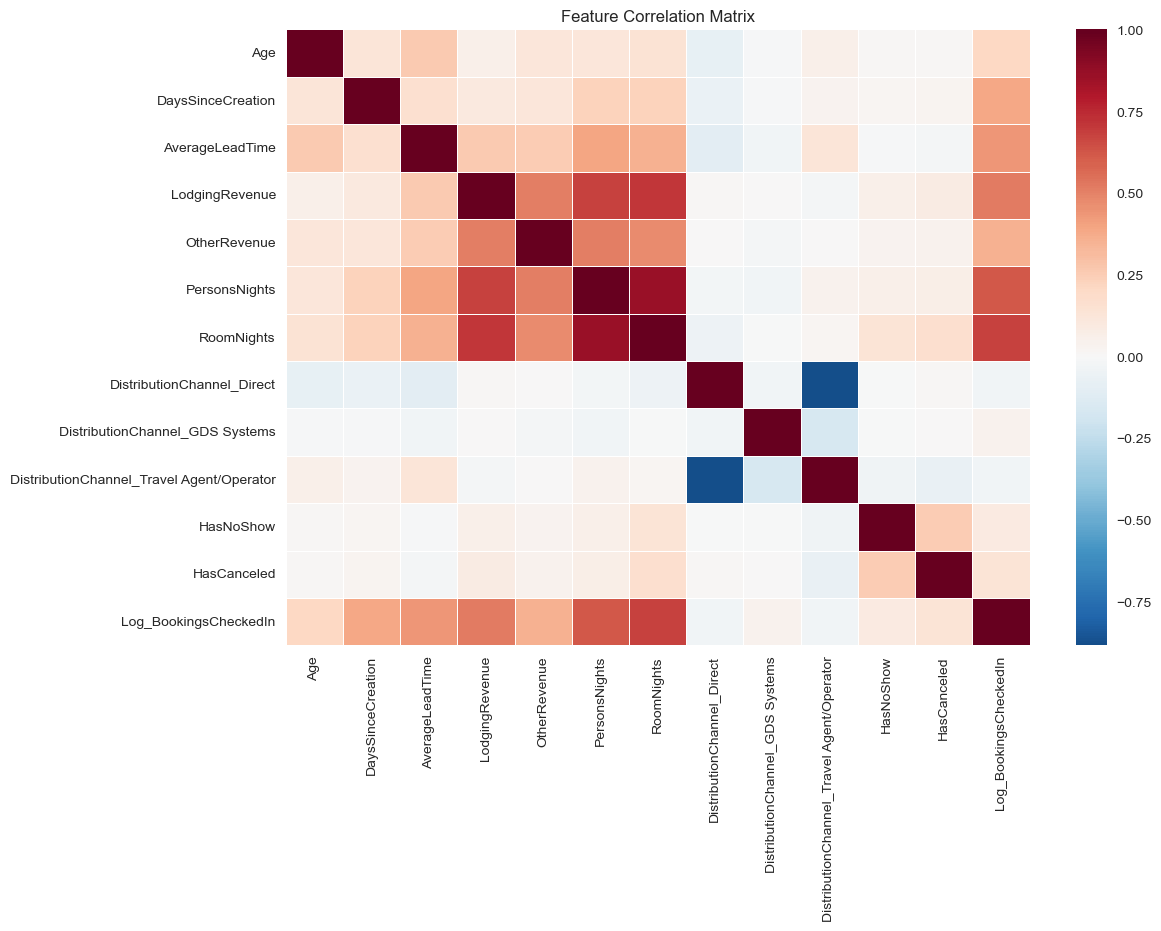

In [965]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]
num_cols = [col for col in data.select_dtypes(include=["number"]).columns if col not in binary_cols]
corr_matrix = data[num_cols].corr()

plt.figure(figsize=(12, 8)) 
sns.heatmap(
    corr_matrix, 
    annot=False,  
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5
)
plt.title("Feature Correlation Matrix")
plt.show()

# Data Preparation

### Missing Values Handling

In [966]:
data['Age'] = data['Age'].fillna(data['Age'].median())

In [967]:
print(data.isnull().sum())

Age                                          0
DaysSinceCreation                            0
AverageLeadTime                              0
LodgingRevenue                               0
OtherRevenue                                 0
PersonsNights                                0
RoomNights                                   0
SRHighFloor                                  0
SRLowFloor                                   0
SRAccessibleRoom                             0
SRMediumFloor                                0
SRBathtub                                    0
SRShower                                     0
SRCrib                                       0
SRKingSizeBed                                0
SRTwinBed                                    0
SRNearElevator                               0
SRAwayFromElevator                           0
SRNoAlcoholInMiniBar                         0
SRQuietRoom                                  0
DistributionChannel_Direct                   0
DistributionC

Remove Negative Values

In [968]:
numerical_cols = data.select_dtypes(include=['number']).columns
data[numerical_cols] = data[numerical_cols].clip(lower=0)

In [969]:
negative_values = (data[numerical_cols] < 0).sum()
print("Negative values after correction:\n", negative_values)

Negative values after correction:
 Age                                          0
DaysSinceCreation                            0
AverageLeadTime                              0
LodgingRevenue                               0
OtherRevenue                                 0
PersonsNights                                0
RoomNights                                   0
SRHighFloor                                  0
SRLowFloor                                   0
SRAccessibleRoom                             0
SRMediumFloor                                0
SRBathtub                                    0
SRShower                                     0
SRCrib                                       0
SRKingSizeBed                                0
SRTwinBed                                    0
SRNearElevator                               0
SRAwayFromElevator                           0
SRNoAlcoholInMiniBar                         0
SRQuietRoom                                  0
DistributionChannel_Direc

### Outliers Handling

In [970]:
data = data[((data['Age'] >= 0) & (data['Age'] <= 100))]

Outliers in (PersonsNights < RoomNights)

In [971]:
invalid_rows = data[data['PersonsNights'] < data['RoomNights']]
data = data[data['PersonsNights'] >= data['RoomNights']]

print(f"Rows eliminated due to PersonsNights < RoomNights: {invalid_rows.shape[0]}")

Rows eliminated due to PersonsNights < RoomNights: 28


Cap and Log Transformation

In [972]:
data

,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,PersonsNights,RoomNights,SRHighFloor,SRLowFloor,SRAccessibleRoom,...,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,DistributionChannel_Direct,DistributionChannel_GDS Systems,DistributionChannel_Travel Agent/Operator,Nationality_Processed,HasNoShow,HasCanceled,Log_BookingsCheckedIn
ID,,,,,,,,,,,,,,,,,,,,,
1,52.0,440,59,292.00,82.3,6,4,0,0,0,...,0,0,0,0,0,0,Nationality_PRT,0,1,1.098612
2,47.0,1385,61,280.00,53.0,10,5,0,0,0,...,0,0,0,0,0,1,Nationality_PRT,0,0,0.693147
3,32.0,1385,0,0.00,0.0,0,0,0,0,0,...,0,0,0,0,0,1,Nationality_DEU,0,0,0.000000
4,61.0,1385,93,240.00,60.0,10,5,0,0,0,...,0,0,0,0,0,1,Nationality_FRA,0,0,0.693147
5,52.0,1385,0,0.00,0.0,0,0,0,0,0,...,0,0,0,0,0,1,Nationality_FRA,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111729,31.0,36,0,0.00,0.0,0,0,0,0,0,...,0,0,0,0,0,1,Nationality_DEU,0,0,0.000000
111730,43.0,36,170,755.25,20.0,10,5,0,0,0,...,0,0,0,0,0,1,Nationality_DEU,0,0,0.693147
111731,37.0,36,0,0.00,0.0,0,0,0,0,0,...,0,0,0,0,0,1,Nationality_DEU,0,0,0.000000


In [973]:
zero_count = (data["LodgingRevenue"] == 0).sum()
print(f"Number of zero values in LodgingRevenue: {zero_count}")
zero_percentage = (data["LodgingRevenue"] == 0).mean() * 100
print(f"Percentage of zero values in LodgingRevenue: {zero_percentage:.2f}%")
other_zero_count = (data["OtherRevenue"] == 0).sum()
print(f"Number of zero values in OtherRevenue: {other_zero_count}")

Number of zero values in LodgingRevenue: 33765
Percentage of zero values in LodgingRevenue: 30.23%
Number of zero values in OtherRevenue: 33549


In [974]:
data["HasLodgingRevenue"] = (data["LodgingRevenue"] > 0).astype(int)
data["HasOtherRevenue"] = (data["OtherRevenue"] > 0).astype(int)

In [975]:
data["LodgingRevenue"] = data["LodgingRevenue"].clip(upper=6000)
data["OtherRevenue"] = data["OtherRevenue"].clip(upper=3000)
data["AverageLeadTime"] = data["AverageLeadTime"].clip(upper=300)
data["PersonsNights"] = data["PersonsNights"].clip(upper=35)
data["RoomNights"] = data["RoomNights"].clip(upper=30)

In [976]:
data["LodgingRevenue_Log"] = np.log1p(data["LodgingRevenue"])
data["OtherRevenue_Log"] = np.log1p(data["OtherRevenue"])
data["AverageLeadTime_Log"] = np.log1p(data["AverageLeadTime"])
data["PersonsNights_Log"] = np.log1p(data["PersonsNights"])
data["RoomNights_Log"] = np.log1p(data["RoomNights"])

In [977]:
data.drop(columns=["LodgingRevenue", "OtherRevenue", "AverageLeadTime", "PersonsNights", "RoomNights"], inplace=True)

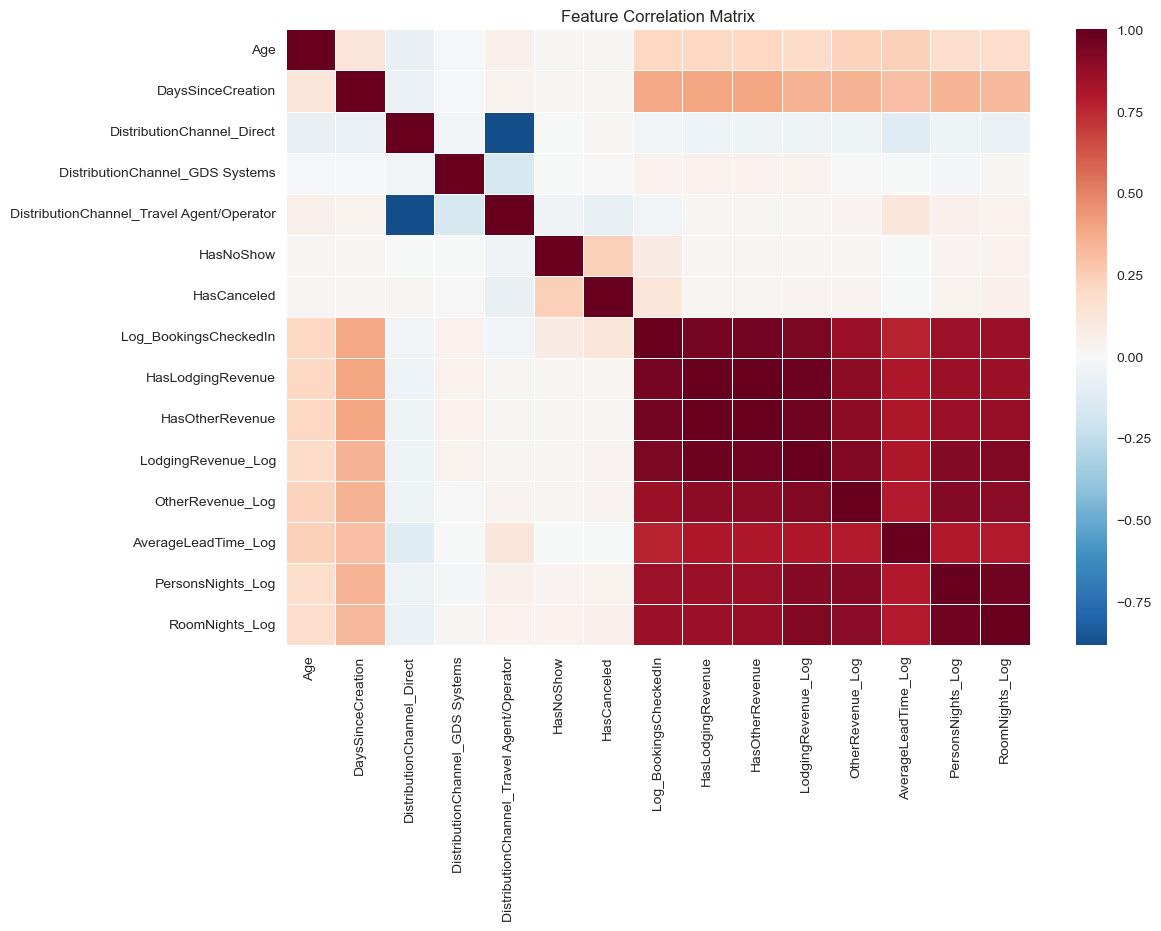

In [978]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]
num_cols = [col for col in data.select_dtypes(include=["number"]).columns if col not in binary_cols]
corr_matrix = data[num_cols].corr()

plt.figure(figsize=(12, 8)) 
sns.heatmap(
    corr_matrix, 
    annot=False,  
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5
)
plt.title("Feature Correlation Matrix")
plt.show()

### Outliers Check

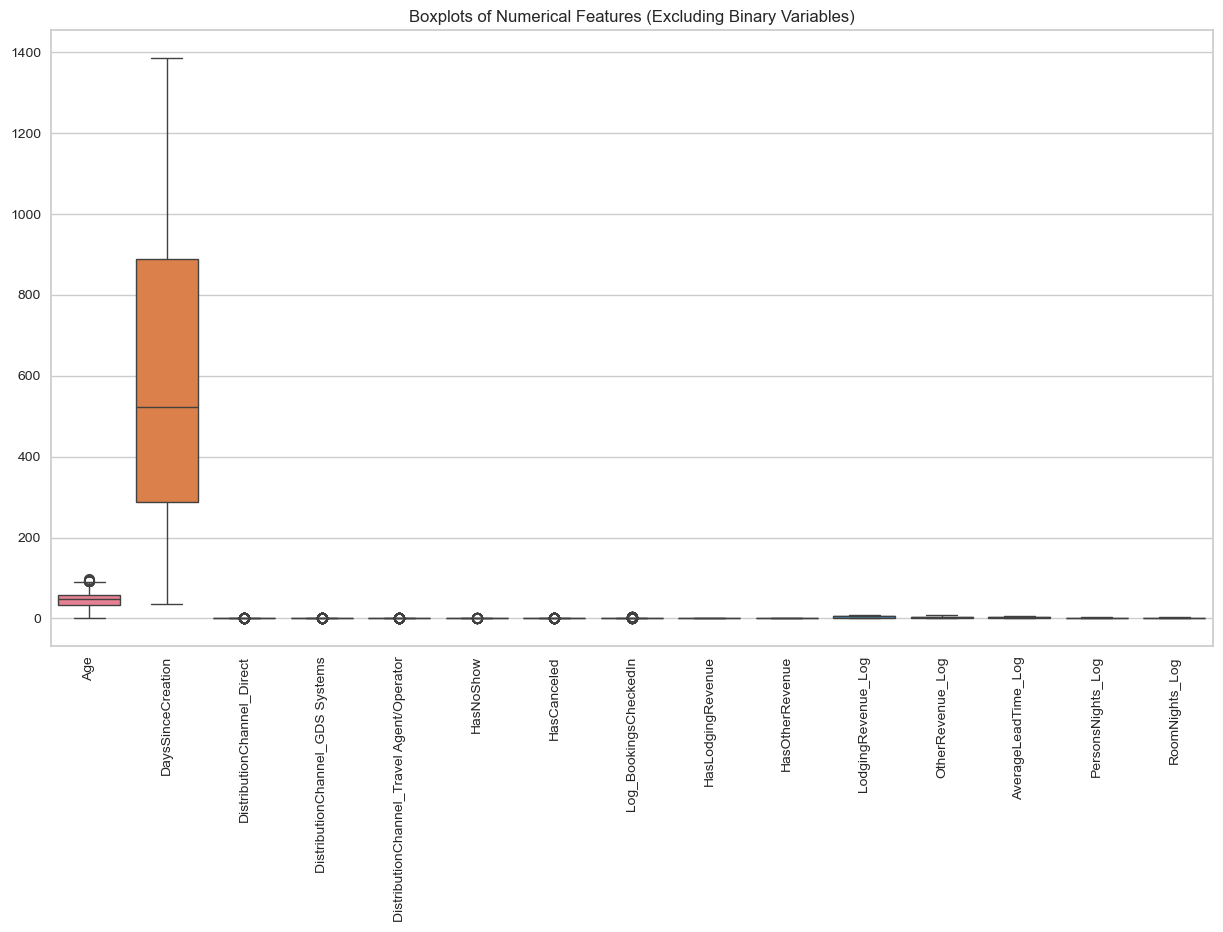

In [979]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]
num_cols = [col for col in data.select_dtypes(include=["number"]).columns if col not in binary_cols]

plt.figure(figsize=(15, 8))
sns.boxplot(data=data[num_cols])
plt.xticks(rotation=90)
plt.title("Boxplots of Numerical Features (Excluding Binary Variables)")
plt.show()

### Merge Features based on the Correlation

In [980]:
data["TotalNights_Log"] = data["PersonsNights_Log"] + data["RoomNights_Log"]
data.drop(columns=["PersonsNights_Log", "RoomNights_Log"], inplace=True)

In [981]:
data["TotalRevenue_Log"] = data["LodgingRevenue_Log"] + data["OtherRevenue_Log"]
data.drop(columns=["LodgingRevenue_Log", "OtherRevenue_Log"], inplace=True)

In [982]:
drop_cols = [
    'SRHighFloor', 'SRLowFloor', 'SRAccessibleRoom', 'SRMediumFloor',
    'SRBathtub', 'SRShower', 'SRCrib', 'SRKingSizeBed', 'SRTwinBed',
    'SRNearElevator', 'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', 'SRQuietRoom'
]

if "Nationality_Processed" in data.columns:
    data.drop(columns=["Nationality_Processed"], inplace=True)

data.drop(columns=drop_cols, inplace=True)
print("Final feature list:")
print(data.columns)
print("Total number of columns:", len(data.columns))

Final feature list:
Index(['Age', 'DaysSinceCreation', 'DistributionChannel_Direct',
       'DistributionChannel_GDS Systems',
       'DistributionChannel_Travel Agent/Operator', 'HasNoShow', 'HasCanceled',
       'Log_BookingsCheckedIn', 'HasLodgingRevenue', 'HasOtherRevenue',
       'AverageLeadTime_Log', 'TotalNights_Log', 'TotalRevenue_Log'],
      dtype='object')
Total number of columns: 13


## 📌 Final Variables

- **`Age`** → Customer's age  
- **`DaysSinceCreation`** → Time since account creation  
- **`DistributionChannel_Direct`** → Whether the booking channel was direct (binary)  
- **`DistributionChannel_GDS Systems`** → Whether the booking was made through GDS systems (binary)  
- **`DistributionChannel_Travel Agent/Operator`** → Whether the booking was made via a travel agent or operator (binary)  
- **`HasNoShow`** → Whether the customer has had a no-show before (binary)  
- **`HasCanceled`** → Whether the customer has canceled a booking before (binary)  
- **`Log_BookingsCheckedIn`** → Number of successfully completed bookings (log-transformed)  
- **`HasLodgingRevenue`** → Whether the customer has generated lodging revenue (binary)  
- **`HasOtherRevenue`** → Whether the customer has generated other revenue (binary)  
- **`AverageLeadTime_Log`** → Average lead time before booking (log-transformed)  
- **`TotalNights_Log`** → Total nights booked (log-transformed)  
- **`TotalRevenue_Log`** → Total revenue generated by the customer (log-transformed)  

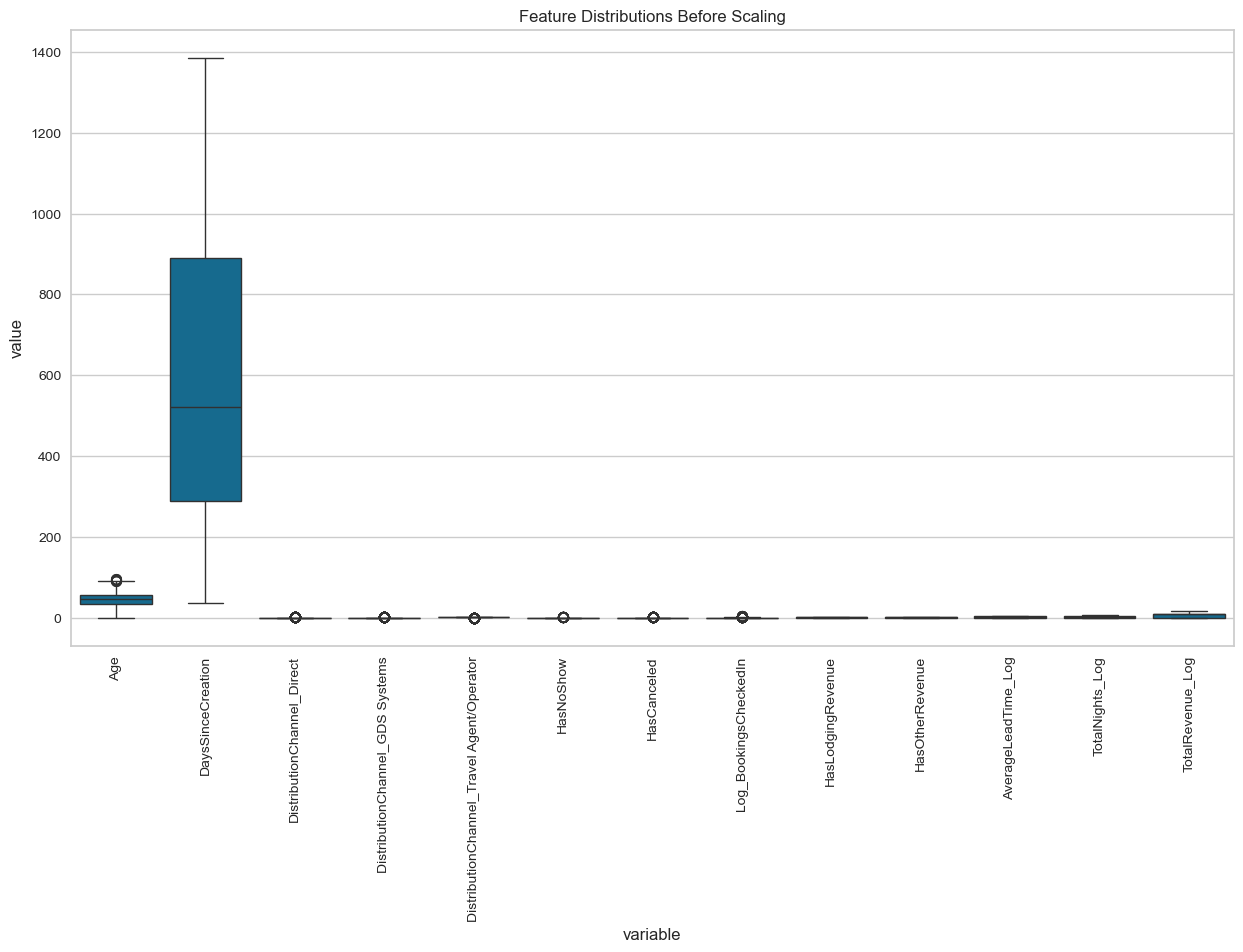

In [983]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot feature distributions
plt.figure(figsize=(15, 8))
data.melt().pipe(sns.boxplot, x='variable', y='value')
plt.xticks(rotation=90)
plt.title("Feature Distributions Before Scaling")
plt.show()


In [984]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Create different scalers
scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler()
}

# Apply each scaler
scaled_dfs = {}
for name, scaler in scalers.items():
    scaled_data = scaler.fit_transform(data)
    scaled_dfs[name] = pd.DataFrame(scaled_data, columns=data.columns)

# Compare mean and variance
for name, df in scaled_dfs.items():
    print(f"\n{name} - Mean:\n{df.mean()}")
    print(f"\n{name} - Variance:\n{df.var()}")



MinMaxScaler - Mean:
Age                                          0.470980
DaysSinceCreation                            0.414375
DistributionChannel_Direct                   0.151071
DistributionChannel_GDS Systems              0.006231
DistributionChannel_Travel Agent/Operator    0.814738
HasNoShow                                    0.000475
HasCanceled                                  0.001424
Log_BookingsCheckedIn                        0.114425
HasLodgingRevenue                            0.697706
HasOtherRevenue                              0.699640
AverageLeadTime_Log                          0.457396
TotalNights_Log                              0.314055
TotalRevenue_Log                             0.407689
dtype: float64

MinMaxScaler - Variance:
Age                                          0.030391
DaysSinceCreation                            0.077133
DistributionChannel_Direct                   0.128250
DistributionChannel_GDS Systems              0.006192
DistributionChannel

### Min Max Scaling

In [985]:
scaler = MinMaxScaler()
min_max_data = scaler.fit_transform(data)
df_min_max_data = pd.DataFrame(min_max_data, columns=data.columns)

### PCA

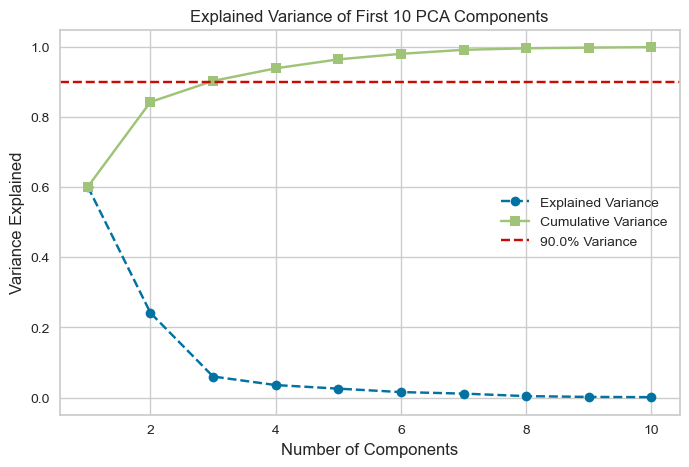

Total variance explained by 10 components: 0.9983


In [986]:
pca = PCA(n_components=10)
data_pca = pca.fit_transform(min_max_data)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label='Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', label='Cumulative Variance')

threshold_var = 0.90  
plt.axhline(y=threshold_var, color='r', linestyle='--', label=f'{threshold_var*100}% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance of First 10 PCA Components')
plt.legend()
plt.show()

total_variance = sum(explained_variance)
print(f"Total variance explained by 10 components: {total_variance:.4f}")
if total_variance < threshold_var:
    print(f"Warning: Less than {threshold_var*100}% variance is explained! Consider increasing n_components.")

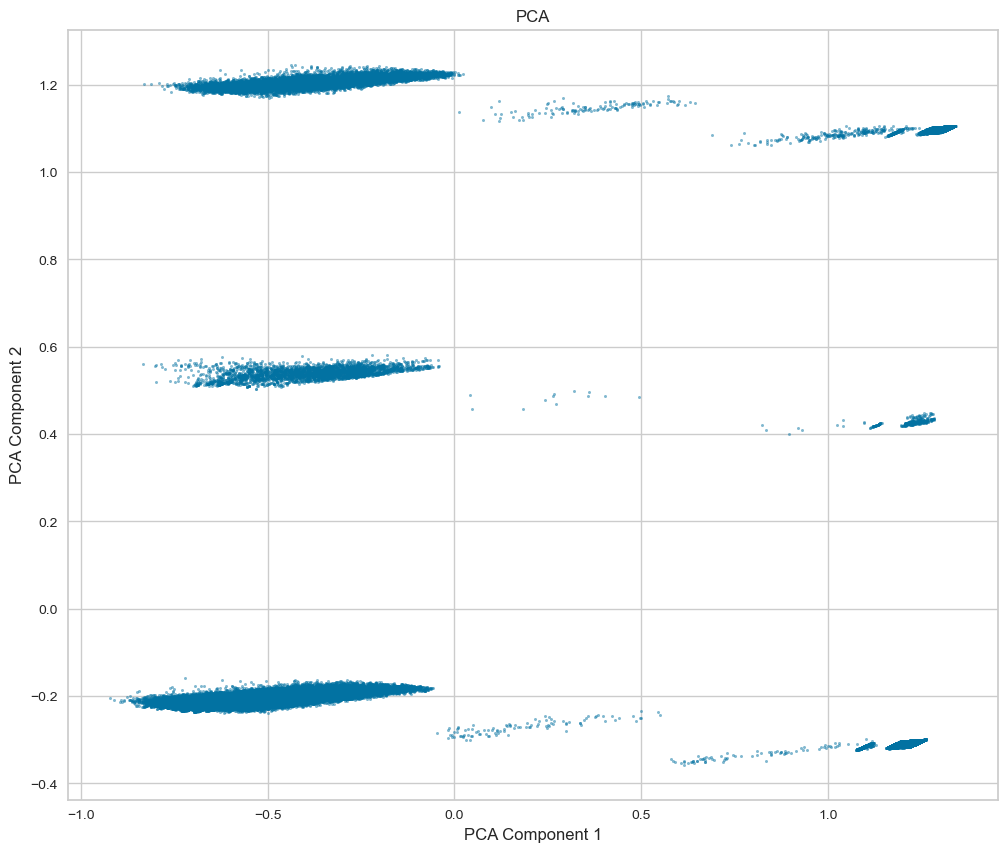

In [988]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(data_pca[:, 0], data_pca[:, 1], s=3, alpha=0.5)
ax.set_title(f"PCA")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
plt.show()

In [989]:
pca_columns = [f"PC{i+1}" for i in range(10)]
df_pca = pd.DataFrame(data_pca, columns=pca_columns)

print(df_pca.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.536375  0.534263 -0.176841 -0.046132  0.106629  0.594468  0.262480   
1 -0.677713 -0.211946  0.470915  0.119086 -0.080107 -0.040585  0.100496   
2  1.100606 -0.313847  0.732452  0.120456 -0.146922  0.006094  0.022248   
3 -0.713586 -0.218060  0.458330  0.217941  0.041572 -0.035279  0.093329   
4  1.090045 -0.317972  0.737225  0.176264  0.050445 -0.008490  0.029901   

        PC8       PC9      PC10  
0 -0.303871  0.151595  0.898691  
1  0.010005  0.064690 -0.018298  
2  0.008999 -0.021192  0.002310  
3  0.010345  0.067764 -0.018760  
4  0.010919 -0.017525  0.000911  


### Check if Clusters Exist (PCA)

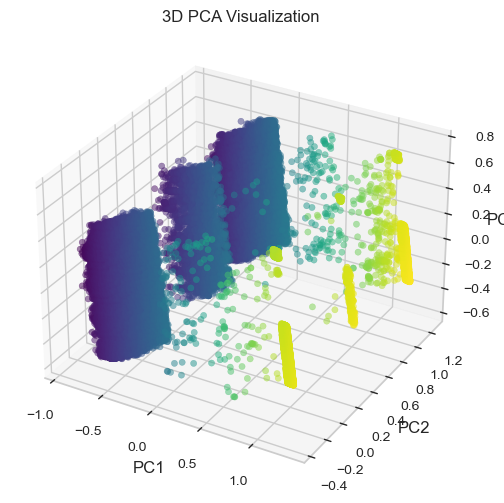

PCA Reduced Data Shape: (111696, 10)


In [990]:
pca_3d = PCA(n_components=3)
data_pca_3d = pca_3d.fit_transform(min_max_data)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2], c=data_pca_3d[:, 0], cmap='viridis', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Visualization')
plt.show()

print(f"PCA Reduced Data Shape: {data_pca.shape}")

### UMAP

c:\Users\gonca\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


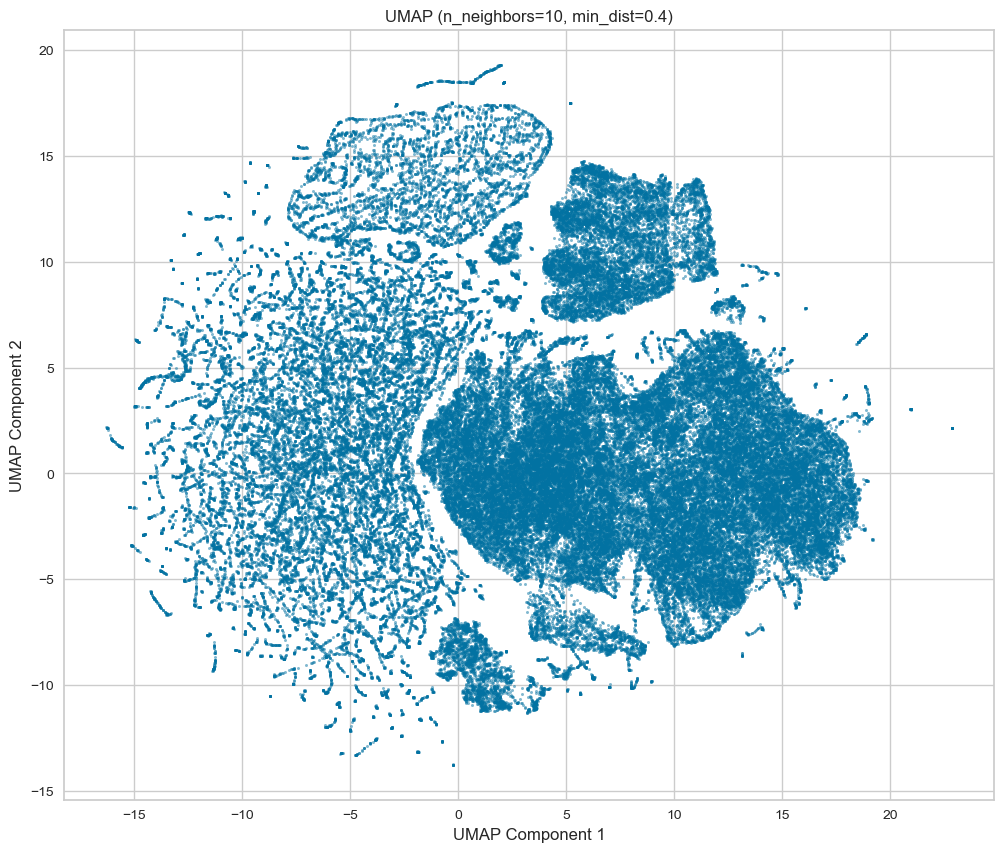

In [991]:
n_neighbors = 10
min_dist = 0.4
umap_reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=123)
data_umap = umap_reducer.fit_transform(min_max_data)

fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(data_umap[:, 0], data_umap[:, 1], s=3, alpha=0.5)
ax.set_title(f"UMAP (n_neighbors={n_neighbors}, min_dist={min_dist})")
ax.set_xlabel("UMAP Component 1")
ax.set_ylabel("UMAP Component 2")
plt.show()

c:\Users\gonca\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


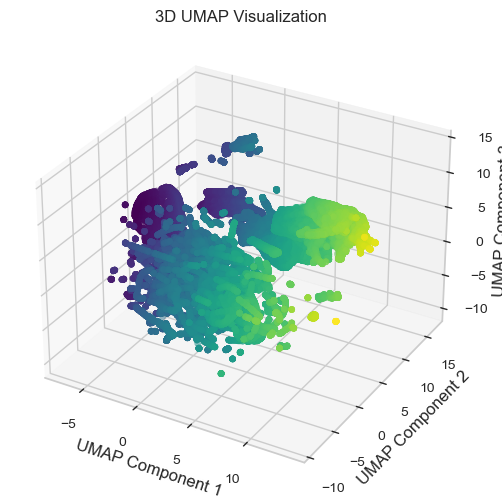

In [992]:
umap_reducer_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=123)
data_umap_3d = umap_reducer_3d.fit_transform(min_max_data)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap_3d[:, 0], data_umap_3d[:, 1], data_umap_3d[:, 2], c=data_umap_3d[:, 0], cmap='viridis', alpha=0.5)
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
ax.set_title('3D UMAP Visualization')
plt.show()

### Comparing PCA and UMAP

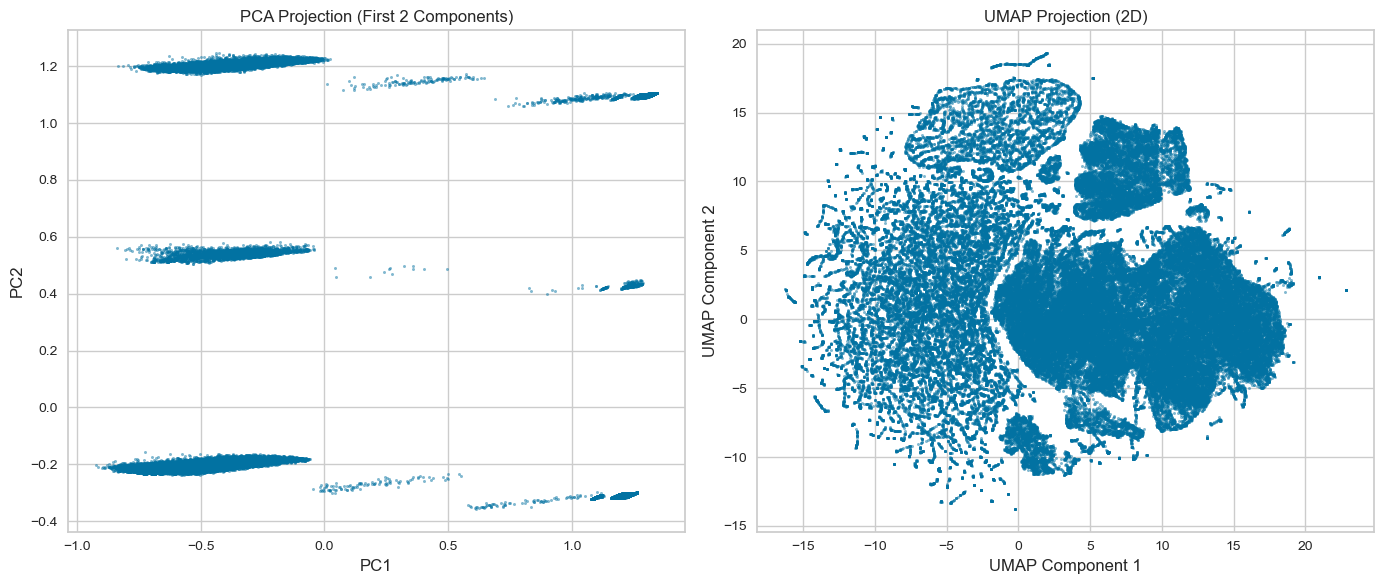

In [993]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA Scatter Plot
axes[0].scatter(data_pca[:, 0], data_pca[:, 1], s=3, alpha=0.5)
axes[0].set_title("PCA Projection (First 2 Components)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# UMAP Scatter Plot
axes[1].scatter(data_umap[:, 0], data_umap[:, 1], s=3, alpha=0.5)
axes[1].set_title("UMAP Projection (2D)")
axes[1].set_xlabel("UMAP Component 1")
axes[1].set_ylabel("UMAP Component 2")

plt.tight_layout()
plt.show()

# Clustering

### K-Means

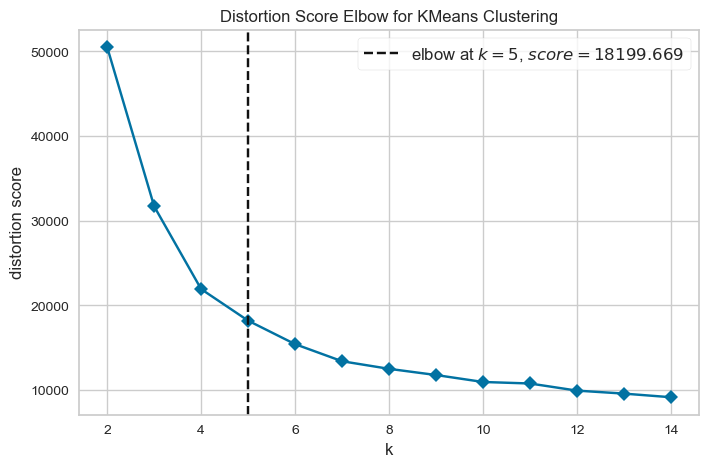

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [994]:
kmeans = KMeans(random_state=123, n_init=10)
plt.figure(figsize=(8, 5))
visualizer = KElbowVisualizer(kmeans, k=(2, 15), metric='distortion', timings=False)
visualizer.fit(min_max_data)
visualizer.show()

In [995]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=123, n_init=10)
df_min_max_data["Cluster"] = kmeans.fit_predict(df_min_max_data)

print(df_min_max_data["Cluster"].value_counts())
data["Cluster"] = df_min_max_data["Cluster"]
data.head()

Cluster
1    34418
4    29393
0    27192
2    14280
3     6413
Name: count, dtype: int64


,Age,DaysSinceCreation,DistributionChannel_Direct,DistributionChannel_GDS Systems,DistributionChannel_Travel Agent/Operator,HasNoShow,HasCanceled,Log_BookingsCheckedIn,HasLodgingRevenue,HasOtherRevenue,AverageLeadTime_Log,TotalNights_Log,TotalRevenue_Log,Cluster
ID,,,,,,,,,,,,,,
1,52.0,440,0,0,0,0,1,1.098612,1,1,4.094345,3.555348,10.102621,1.0
2,47.0,1385,0,0,1,0,0,0.693147,1,1,4.127134,4.189655,9.627339,0.0
3,32.0,1385,0,0,1,0,0,0.000000,0,0,0.000000,0.000000,0.000000,1.0
4,61.0,1385,0,0,1,0,0,0.693147,1,1,4.543295,4.189655,9.595671,0.0
5,52.0,1385,0,0,1,0,0,0.000000,0,0,0.000000,0.000000,0.000000,1.0


In [996]:
silhouette_score_minmax = silhouette_score(df_min_max_data.drop(columns=["Cluster"]), df_min_max_data["Cluster"])
print(f"Silhouette Score: {silhouette_score_minmax:.4f}")

Silhouette Score: 0.4377


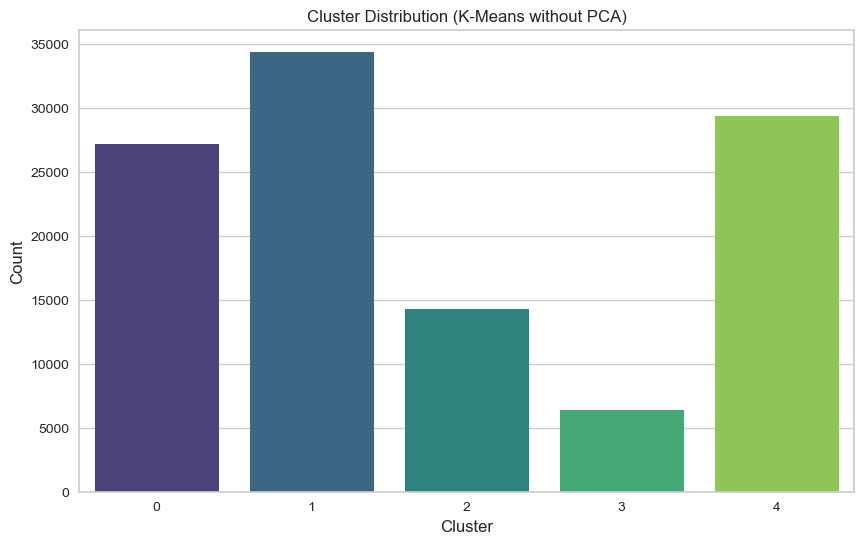

In [997]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df_min_max_data["Cluster"], palette="viridis")
plt.title("Cluster Distribution (K-Means without PCA)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

In [998]:
cluster_means = data.groupby("Cluster").mean()
print(cluster_means)

               Age  DaysSinceCreation  DistributionChannel_Direct  \
Cluster                                                             
0.0      43.832015         366.334829                    0.160958   
1.0      48.910359        1002.476718                    0.117254   
2.0      45.547734         651.015059                    0.159557   
3.0      43.167993         382.501482                    0.214319   
4.0      44.236413         349.276842                    0.163621   

         DistributionChannel_GDS Systems  \
Cluster                                    
0.0                             0.005555   
1.0                             0.005087   
2.0                             0.009526   
3.0                             0.006863   
4.0                             0.006466   

         DistributionChannel_Travel Agent/Operator  HasNoShow  HasCanceled  \
Cluster                                                                      
0.0                                       0.811891 

### K-Means with PCA

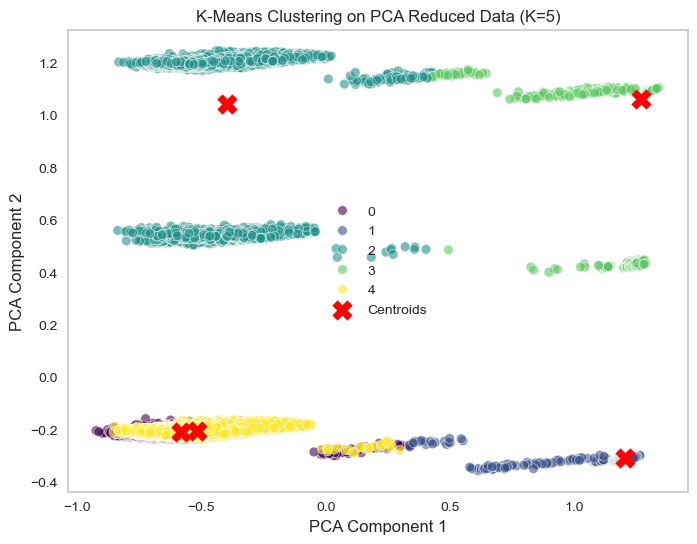

Cluster Distribution: {0: 34449, 1: 27192, 2: 14280, 3: 6413, 4: 29362}


In [999]:
n_pca_components = 5
pca = PCA(n_components=n_pca_components)
data_pca = pca.fit_transform(min_max_data)
kmeans_pca = KMeans(n_clusters=5, random_state=123, n_init=10)
y_kmeans_pca = kmeans_pca.fit_predict(data_pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=y_kmeans_pca, palette="viridis", alpha=0.6)
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], s=200, c="red", marker="X", label="Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering on PCA Reduced Data (K=5)")
plt.legend()
plt.grid()
plt.show()

unique, counts = np.unique(y_kmeans_pca, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print(f"Cluster Distribution: {cluster_distribution}")

In [1000]:
silhouette_avg = silhouette_score(data_pca, y_kmeans_pca)
print(f"Silhouette Score with PCA: {silhouette_avg:.4f}")

Silhouette Score with PCA: 0.4692


In [1001]:
pca_cluster_means = pd.DataFrame(kmeans_pca.cluster_centers_, columns=[f"PC{i+1}" for i in range(n_pca_components)])
print(pca_cluster_means)

        PC1       PC2       PC3       PC4       PC5
0 -0.581939 -0.210032  0.214318  0.033530 -0.013100
1  1.204906 -0.309622  0.001157  0.017752  0.002450
2 -0.394939  1.042945  0.006433 -0.069111  0.033133
3  1.269648  1.059857  0.011795  0.128458 -0.041760
4 -0.518279 -0.205551 -0.258579 -0.050287  0.006122


### K-Means with UMAP

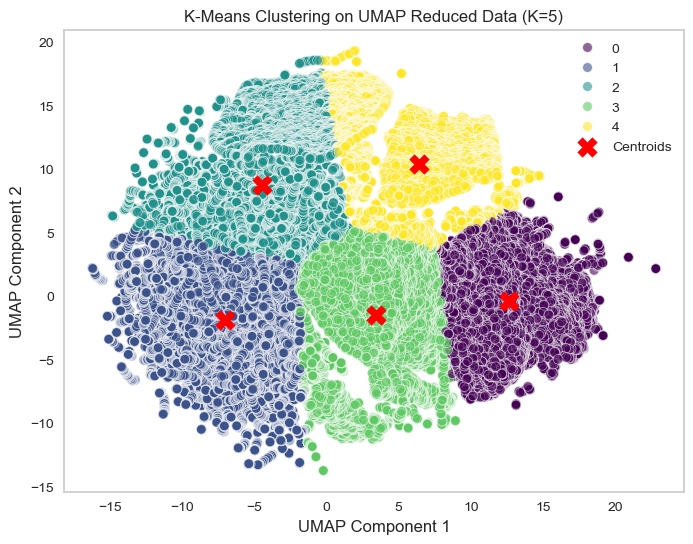

Cluster Distribution: {0: 32078, 1: 16600, 2: 14457, 3: 32335, 4: 16226}


In [1002]:
kmeans_umap = KMeans(n_clusters=5, random_state=123, n_init=10)
y_kmeans_umap = kmeans_umap.fit_predict(data_umap)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:, 1], hue=y_kmeans_umap, palette="viridis", alpha=0.6)
plt.scatter(kmeans_umap.cluster_centers_[:, 0], kmeans_umap.cluster_centers_[:, 1], s=200, c="red", marker="X", label="Centroids")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("K-Means Clustering on UMAP Reduced Data (K=5)")
plt.legend()
plt.grid()
plt.show()

unique, counts = np.unique(y_kmeans_umap, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print(f"Cluster Distribution: {cluster_distribution}")

In [ ]:
"""
Analisar os Clusters: Estatisticas, visualizar e finalmente descrever
"""